In [1]:
# import libs
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns 
# sns.set_palette(sns.color_palette("Paired"))

import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei']#指定默认字体  
mpl.rcParams['axes.unicode_minus'] =False # 解决保存图像是负号'-'显示为方块的问题
#sns.axes_style()，可以看到是否成功设定字体为微软雅黑。

sns.set_context("talk")


import sys
sys.path.append('../')

import pyasset.optimizer as opt

# 1. Markovitz 均值方差分析存在的问题
最大化效用函数 U


$
U(x) = x^{T}(\mu-rI) - \frac{\phi}{2}x^{T}\Sigma x
$


在没有其它约束的情况下


$
x^* = arg max U(x) = \frac{1}{\phi} \Sigma^{-1}(\mu-rI)
$

1. 待估计参数
2. 不稳定性

## 1.1 待估计参数
通常利用历史数据进行估计

$
\hat{\mu} = \frac{1}{T}\Sigma_{t=1}^{T}R_{t}
$

$
\hat{\Sigma} = \frac{1}{T}\Sigma_{t=1}^{T}(R_t-\hat{\mu})(R_t-\hat{\mu})^T
$

因此，如果我们有n个风险资产，则需要估计n个期望收益，n个资产收益的波动率和n(n-1)/2个相关系数

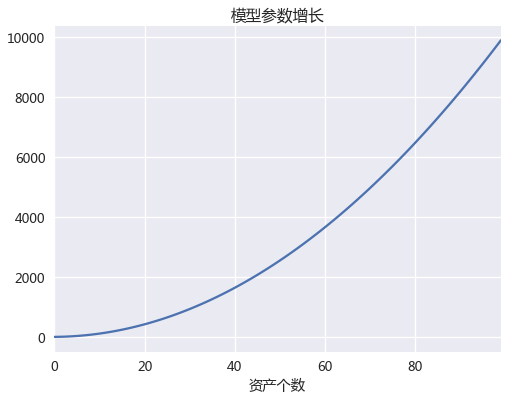

In [2]:
n_asset = range(100)
n_parameters = [n+n**2 for n in n_asset]
s_para = pd.Series(n_parameters, index=n_asset, name='资产个数')

plt.xlabel('资产个数')
s_para.plot(title='模型参数增长', figsize=(8, 6))

## 1.2 不稳定性

In [3]:
# Example 1
mu   = [0.05, 0.06, 0.07, 0.08]
mu_s = [0.06, 0.06, 0.07, 0.08] # mu_1 add 0.01

sig   = [0.10, 0.12, 0.14, 0.15]
sig_s = [0.10, 0.15, 0.14, 0.15] # sig_2 add 0.03

rou = 0.7
rou_s = 0.8 # rou add 0.1

def gen_cov(mu, sig, rou):
    """生成方差协方差矩阵"""
    cov = np.diag(np.array(sig)**2)
    for i in range(len(mu)):
        for j in range(4):
            if i ==j :
                continue
            cov[i][j] = sig[i] * sig[j] * rou
    return cov

cov0 = gen_cov(mu, sig, rou)
cov1 = gen_cov(mu_s, sig, rou)
cov2 = gen_cov(mu, sig_s, rou)
cov3 = gen_cov(mu, sig, rou_s)


# 组成df
index = ['mu1', 'sig2', 'rou', 'w1', 'w2', 'w3', 'w4']
df = pd.DataFrame([])

w0 = [mu[0], sig[1], rou]
w0 = w0+list(opt.Markovitz_solver(mu, cov0, tau=3))
w0 = pd.Series(w0, index=index)
df['w0'] = w0

w1 = [mu_s[0], sig[1], rou]
w1 = w1+list(opt.Markovitz_solver(mu_s, cov1, tau=3))
w1 = pd.Series(w1, index=index)
df['w1'] = w1

w2 = [mu[0], sig_s[1], rou]
w2 = w2+list(opt.Markovitz_solver(mu, cov2, tau=3))
w2 = pd.Series(w2, index=index)
df['w2'] = w2

w3 = [mu[0], sig[1], rou_s]
w3 = w3+list(opt.Markovitz_solver(mu, cov3, tau=3))
w3 = pd.Series(w3, index=index)
df['w3'] = w3

df

,w0,w1,w2,w3
mu1,0.050000,0.060000,0.050000,0.050000
sig2,0.120000,0.120000,0.150000,0.120000
rou,0.700000,0.700000,0.700000,0.800000
w1,-0.158496,0.437486,0.028734,-0.228015
w2,0.178173,-0.117258,-0.239720,0.144813
w3,0.342670,0.171388,0.463053,0.329121
w4,0.637653,0.508384,0.747934,0.754081


In [4]:
# 画有效前沿边界
def rand_weight(n):
    k = np.random.randn(n)
    return k/sum(k)

def random_portfolio(r, C):
    w = rand_weight(len(r))
    mu = np.dot(w, r)
    sigma = np.sqrt(np.dot(w, np.dot(w, C)))
    
    if sigma > 0.5:
        return random_portfolio(r, C)
    else:
        return mu, sigma

In [5]:
n_portfolios = 1000
means, stds = np.column_stack([
    random_portfolio(mu, cov0)
    for _ in range(n_portfolios)
])

In [6]:
taus = [np.log(a**3+1) for a in range(100)]
weights = [opt.Markovitz_solver(mu, cov0, tau=t) for t in taus]
opt_means = [np.dot(w, mu) for w in weights]
opt_stds = [np.sqrt(np.dot(w, np.dot(w, cov0))) for w in weights]

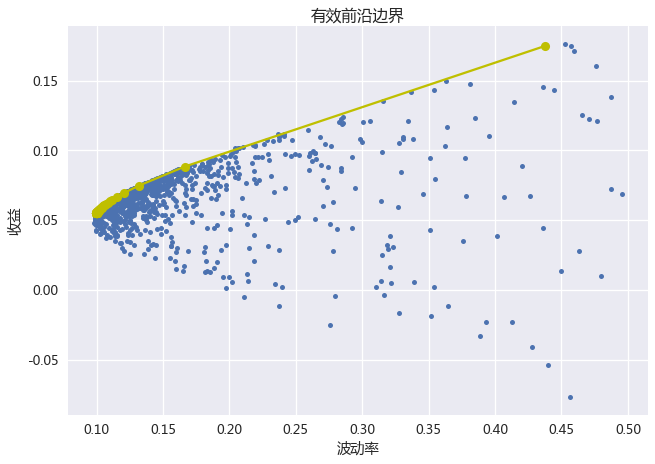

In [7]:
plt.plot(stds, means, 'o', markersize=5)
plt.xlabel('波动率')
plt.ylabel('收益')
plt.title('有效前沿边界')

plt.plot(opt_stds, opt_means, 'y-o')

# WHY?
$
x^* = arg max U(x) = \frac{1}{\phi} \Sigma^{-1}(\mu-rI)
$

information matrix $\Sigma^{-1}$


## 1.3
- **Approach 1: Reduce estimation errors**
    - Resampling approach(Michaud,1998)
    - Bayes method(Black and Litterman, 1992)

- **Approach 2: Regularization method**
    - Imposing constrains(Jagannathan and Ma, 2003)
    - Regularization of input parameters, shrinkage(Ledoit and Wolf, 2003)
        
        $
        \hat{\Sigma_\alpha} = \alpha\hat{\Phi} + (1-\alpha)\hat{\Sigma}
        $
    
    - penalization of the objective function(L1 or L2)
        
        $ x^*(\lambda) = arg max \{x^{T}\hat{\mu} - \frac{\phi}{2}x^T\hat{\Sigma}x - \lambda||x|| \}$
        
        $u.c. I^Tx = 1$
                
        $ x^*(\lambda) = arg max \{x^{T}\hat{\mu} - \frac{\phi}{2}x^T\hat{\Sigma}x - \lambda x^Tx \}$
        
        $u.c. I^Tx = 1$
        
    - Example
    
        $ x^*(\lambda) = arg max \{x^{T}\hat{\mu} - \frac{\phi}{2}x^T\hat{\Sigma}x - \lambda||x-x_0|| \}$
        
        $x^*(\lambda) = arg max \{x^{T}\hat{\mu} - \frac{\phi}{2}x^T\hat{\Sigma}x - \lambda (x-x_0)^TA(x-x_0) \}$
        
       

- **Approach 3: Risk Budget Approach (Roncalli, 2013)**
    - Key Idea: Equal risk contribution
    - Risk Parity Strategy


# 2 Risk Parity

- 适用于美国公共养老金计划等机构投资者，每年3%-5%的固定给定，需要比较稳定的收益。
- 雏形是Bridewater的“全天候”策略——建立在一个任何经济环境下都能表现不错的组合
- 概念：基于目标风险水平，有多种资产构成投资组合，并给组合中的不同资产分配相同风险权重的一种投资策略。

## 2.1 风险平价策略的2假设
1. 所有的风险资产都存在风险溢价，风险越大，收益越高
2. 所有资产的sharpe ratio相同。那么施加一个低杠杆在高风险资产，或者加一个高杠杆在低风险资产，在相同的风险水平下可以得到相同的回报。

# 2.2 风险平价的优势
1. 不需要对收益进行预测
2. 风险的分散化
3. 追求绝对收益
4. 平滑业绩曲线

## 2.3 风险平价的劣势
1. 风险不等于“波动”
2. 资产收益的厚尾分布

### Marginal Contribution to Risk
$MCR_i = \frac{\partial\sigma(w)}{\partial w_i}$

- 风险平价：$w_i * MCR_i = w_j * MCR_j = constant$
- 波动率平价：$w_i * \sigma_i = w_j * \sigma_j$
- 均值方差：$\frac{MCR_i}{\mu_i}=\frac{MCR_j}{\mu_j}$


### Risk Parity Problem
$Max \quad \Sigma_i^N \log(|w_i|)$

s.t. $\sigma(w) = \sqrt{w^T\Sigma w} \le \sigma_{target}$ or $\Sigma(w_i)=1$

- FLORIN SPINU (2013), AN ALGORITHM FOR COMPUTING RISK PARITY WEIGHTS

# 3. Example

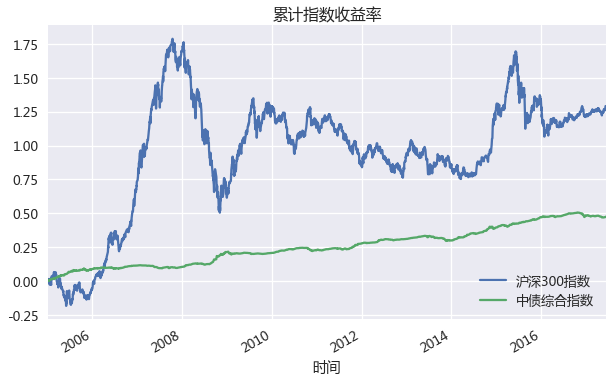

In [8]:
db = pd.HDFStore('..\pyasset\DB.h5')
ret_all = db['asset_ret']
ret = ret_all[['沪深300指数', '中债综合指数']]
ret = ret.dropna()
db.close()

ret.index.name = "时间"
np.log((1+ret)).cumsum().plot(figsize=(10, 6), title='累计指数收益率')

# ret

In [9]:
# import libs
from pyasset.estimator import Estimator
from pyasset.allocation import Allocation
from pyasset.backtest import Backtest
from pyasset.config import TRADING_DAYS_A_YEAR
from pyasset.xray import Xray

In [10]:
# 估计参数
m_estimator = Estimator(ret)
ret_xp = m_estimator.ewm(halflife=120).mean().shift(1)
ret_xp = (ret_xp+1)**TRADING_DAYS_A_YEAR - 1 # 年化

cov_xp = m_estimator.ewm(halflife=20).cov().shift(1, axis=0)
cov_xp = cov_xp * TRADING_DAYS_A_YEAR # 年化

m_allocation = Allocation(ret_xp, cov_xp, 'Q','2005-12-31', '2017-05-31')
m_allocation.get_rebalance_info()

weight_m_fix = m_allocation.get_equal_weight()
# weight_m_vol_parity = m_allocation.get_volatility_parity_weight()
weight_m_rp = m_allocation.get_risk_parity_weight()
weight_m_mv = m_allocation.get_mean_variance_weight(target_vol=0.3, bound=[(0,1)]*ret.shape[1])


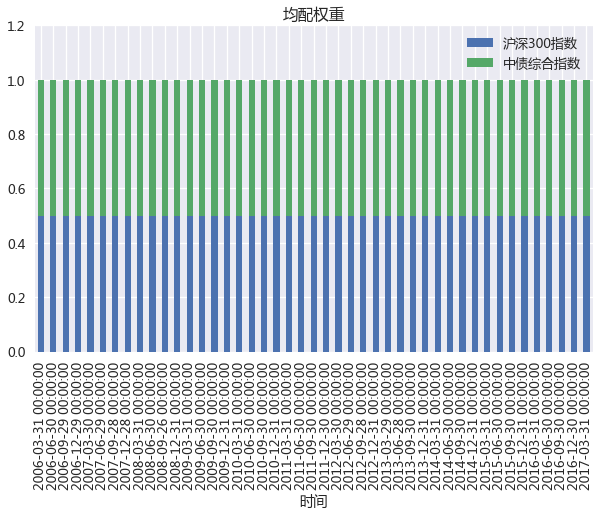

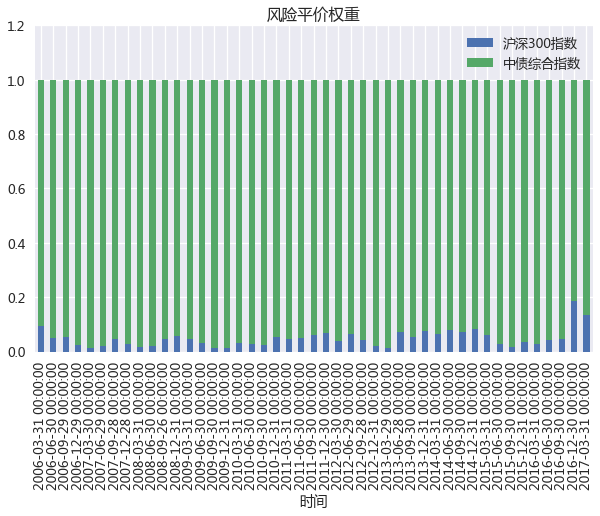

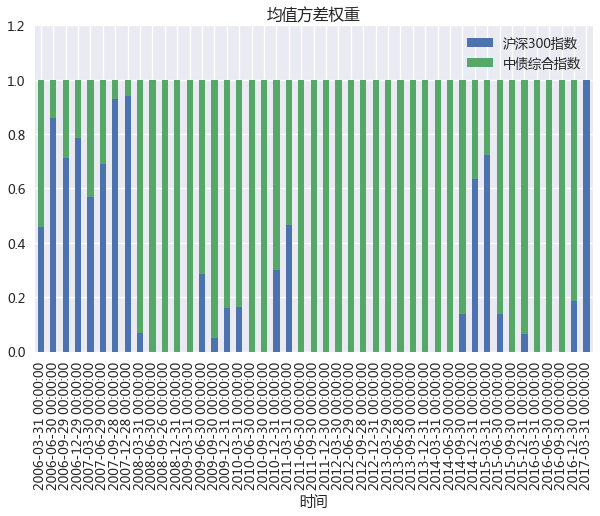

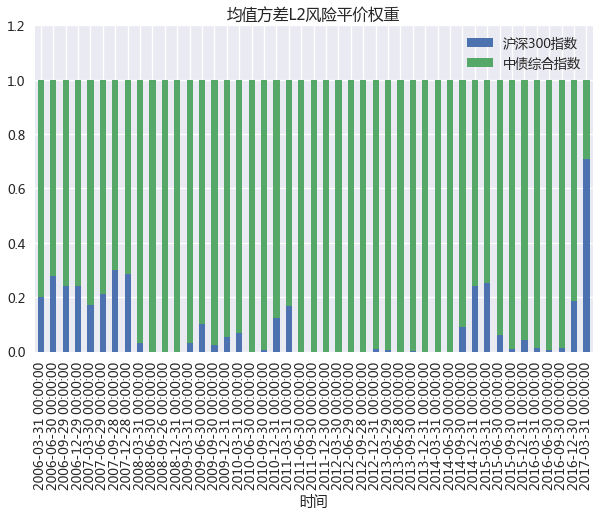

In [11]:
# 权重画图
# weight_m_fix.index = [a.strftime('%Y-%m-%d') for a in weight_m_fix.index]
weight_m_fix.plot(title='均配权重', kind='bar', stacked=True, figsize=(10, 6), ylim=(0,1.2))

weight_m_rp.plot(title='风险平价权重', kind='bar', stacked=True, figsize=(10, 6), ylim=(0,1.2))
weight_m_mv.plot(title='均值方差权重', kind='bar', stacked=True, figsize=(10, 6), ylim=(0,1.2))

# penalty l2 to rp
weight_m_l2 = []
for day in m_allocation.ret_xp_trading.columns:
    xb = weight_m_rp.T[day]
    r = m_allocation.ret_xp_trading[day]
    C = m_allocation.cov_xp_trading[day]
    A = np.diag(np.diag(C))
    weight_m_l2.append(opt.Markovitz_l2_penalty(r, C, xb, A, target_vol=0.3, bound=[(0,1)]*ret.shape[1], lmbd=2.5))

weight_m_l2 = pd.DataFrame(weight_m_l2, index=m_allocation.ret_xp_trading.columns, columns=m_allocation.ret_xp_trading.index)
weight_m_l2.plot(title='均值方差L2风险平价权重', kind='bar', stacked=True, figsize=(10, 6), ylim=(0,1.2))

,等权,均值方差,风险平价,均值方差L2风险平价
Annal ret,9.53%,11.64%,4.61%,7.02%
Annal vol,14.76%,13.02%,1.88%,4.62%
Average turnover,7.38%,27.19%,4.59%,10.64%
IR,0.69,0.91,2.4,1.5
Max Drawdown,-42.41%,-34.02%,-3.20%,-10.06%
Max_wait,1756 Days,1823 Days,252 Days,490 Days
Mdd_end,2008-11-04,2008-03-27,2016-12-20,2008-07-02
Mdd_range,386 Days,164 Days,58 Days,261 Days
Mdd_start,2007-10-16,2007-10-16,2016-10-24,2007-10-16


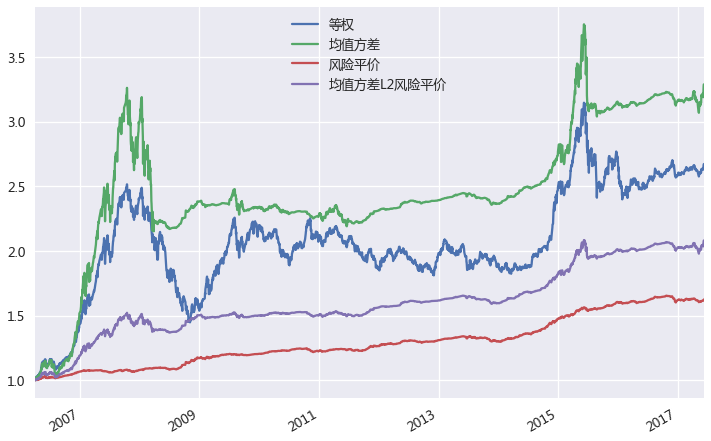

In [12]:
#  回测，千三的手续费
back_test_result = pd.DataFrame([])
plt.figure(figsize=(12,8))

b1 = Backtest(weight_m_fix, ret)
back_test_result['等权'] = b1.analyze()['value']
b1.res_nv.plot(legend=True, label='等权')

b2 = Backtest(weight_m_mv, ret)
back_test_result['均值方差'] = b2.analyze()['value']
b2.res_nv.plot(legend=True, label='均值方差')

b3 = Backtest(weight_m_rp, ret)
back_test_result['风险平价'] = b3.analyze()['value']
b3.res_nv.plot(legend=True, label='风险平价')

b4 = Backtest(weight_m_l2, ret)
back_test_result['均值方差L2风险平价'] = b4.analyze()['value']
b4.res_nv.plot(legend=True, label='均值方差L2风险平价')

back_test_result = back_test_result.sort_index()
back_test_result

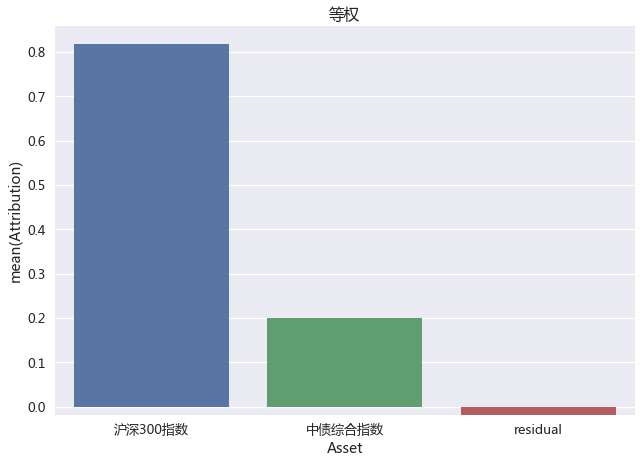

,Attribution
沪深300指数,0.817126
中债综合指数,0.200593
residual,-0.017719


In [13]:
xray1 = Xray(b1, strategy_name='等权')
xray1.return_analyser(plot=True)

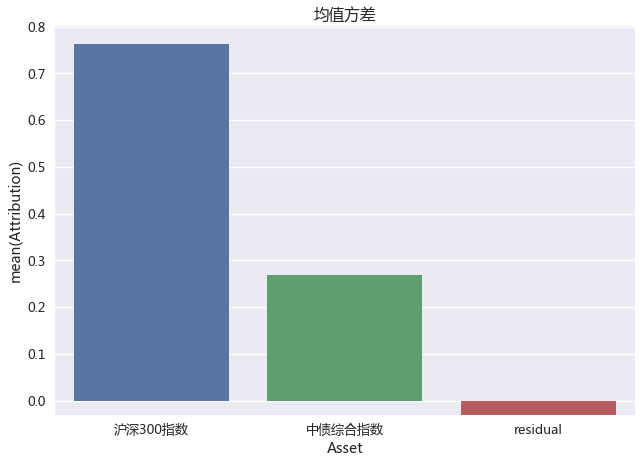

,Attribution
沪深300指数,0.761886
中债综合指数,0.267862
residual,-0.029748


In [14]:
xray2 = Xray(b2, strategy_name ='均值方差')
xray2.return_analyser(plot=True)


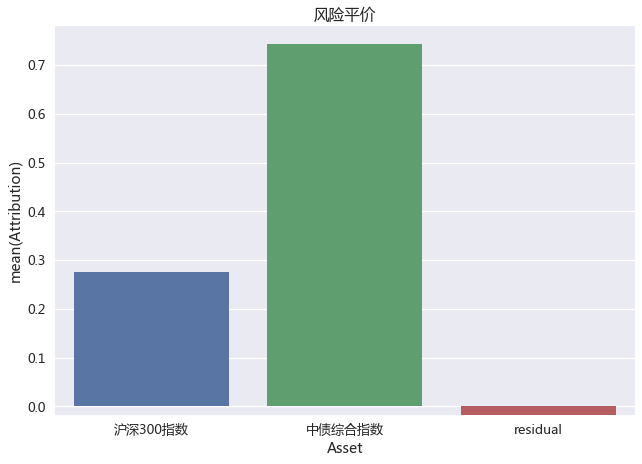

,Attribution
沪深300指数,0.274530
中债综合指数,0.742190
residual,-0.016719


In [15]:
xray3 = Xray(b3, strategy_name = '风险平价')
xray3.return_analyser(plot=True)

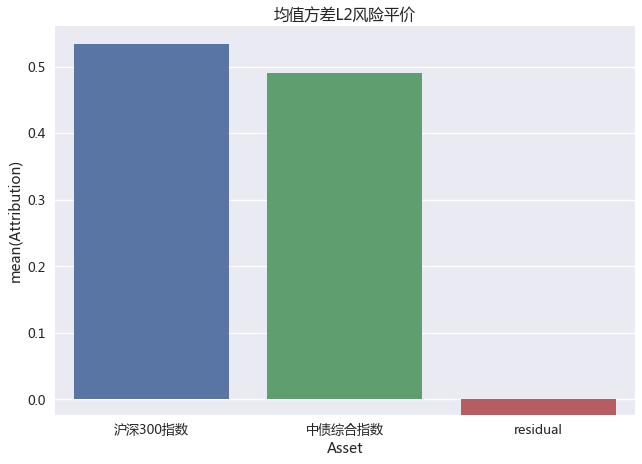

,Attribution
沪深300指数,0.533230
中债综合指数,0.489539
residual,-0.022769


In [16]:
xray4 = Xray(b4, strategy_name='均值方差L2风险平价')
xray4.return_analyser(plot=True)

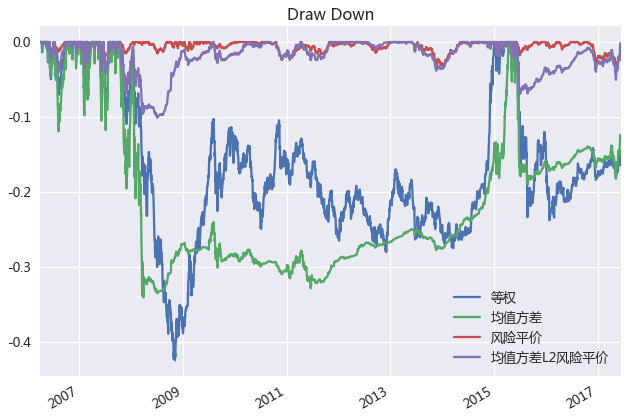

In [17]:
xray1.draw_down_plot()
xray2.draw_down_plot()
xray3.draw_down_plot()
xray4.draw_down_plot()

# 各资产风险收益特征

In [18]:
ret_all = ret_all.dropna()

In [19]:
ret_all = ret_all[['沪深300指数','上证50指数','中证500指数','中债综合指数','中债国债总指数', '中债信用债总指数', '中证基金指数:货币基金']]

,收益,波动率
沪深300指数,14.288423,401.573224
上证50指数,14.670004,416.005733
中证500指数,16.235575,466.886611
中债综合指数,3.609603,23.026216
中债国债总指数,2.905537,36.377318
中债信用债总指数,4.622538,19.149744
中证基金指数:货币基金,3.640255,2.773354


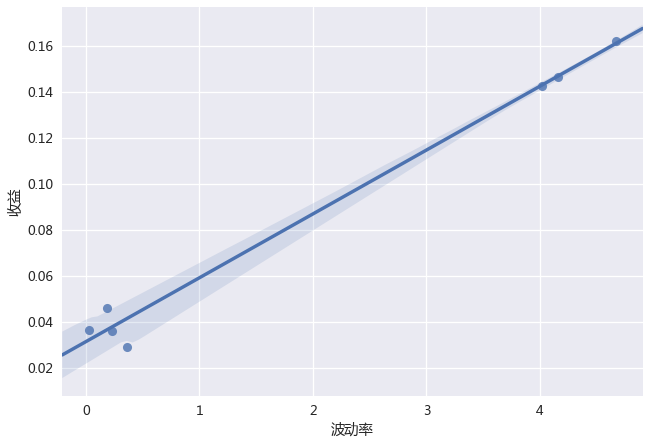

In [20]:
df_asset = pd.DataFrame([])
df_asset['收益'] = ret_all.mean()*TRADING_DAYS_A_YEAR
df_asset['波动率'] = ret_all.std()*TRADING_DAYS_A_YEAR
# df_asset = df_asset.set_index('波动率')
sns.regplot(x='波动率', y='收益', data=df_asset);
df_asset*100

In [22]:
fund_ret = pd.read_excel(r'..\pyasset\asset_index.xlsx', sheetname='基金指数')
# fund_ret.columns = fund_ret.ix[0]
fund_ret = fund_ret.drop([0,1]).set_index(fund_ret.columns[0])
fund_ret.head()

,930609.CSI,930610.CSI,930890.CSI,930892.CSI,930950.CSI,H11021.CSI,H11022.CSI,H11023.CSI,H11025.CSI,H11026.CSI
Wind资讯,,,,,,,,,,
2005-01-04,NaN,NaN,NaN,-1.31291,NaN,-1.4571,-1.21323,-0.458182,0.030831,NaN
2005-01-05,NaN,NaN,NaN,0.28066,NaN,0.340017,0.263652,0.123516,0.009056,NaN
2005-01-06,NaN,NaN,NaN,-0.615192,NaN,-0.660353,-0.554482,-0.062646,0.009199,NaN
2005-01-07,NaN,NaN,NaN,-0.147363,NaN,-0.156564,-0.104756,0.008679,0.0084,NaN
2005-01-10,NaN,NaN,NaN,0.520129,NaN,0.605339,0.525176,0.181289,0.023274,NaN


,收益,波动率
930609.CSI,4.790990,18.007976
930610.CSI,4.817011,27.150052
930890.CSI,4.671747,417.097880
930892.CSI,16.610802,364.886724
930950.CSI,3.642737,401.640654
H11021.CSI,17.800206,385.016426
H11022.CSI,16.859245,307.713121
H11023.CSI,7.303657,51.767864
H11025.CSI,3.139999,2.792262
H11026.CSI,2.155813,278.542820


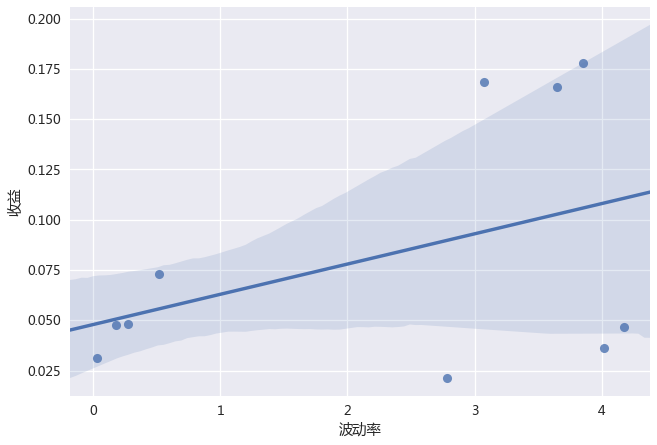

In [23]:
df_asset = pd.DataFrame([])
df_asset['收益'] = fund_ret.mean()*TRADING_DAYS_A_YEAR/100
df_asset['波动率'] = fund_ret.std()*TRADING_DAYS_A_YEAR/100
# df_asset = df_asset.set_index('波动率')
sns.regplot(x='波动率', y='收益', data=df_asset)
df_asset*100